# Programming for Data Science and Artificial Intelligence

## 9. Ensemble

Ensemble is the idea of finding aggregated answers from multiple classifiers.  Indeed, Random Forests are one example of ensembles.  

### Voting Classifiers

#### Hard voting
Suppose you have trained a few classifiers, each one achieving about 80% accuracy.  A simple way to create a better classifier is to predict the class that gets the most votes.  This majority-vote classifier is called **hard voting** classifier.

Somewhat surprisingly, this voting classifier often achieves a higher accuracy then ensemble.  In fact, even each classifier is a *weak learner* (i.e., could simply be a random guesser), their ensembles can be *strong learner*.

One strong tip is that ensemble methods works best when **classifiers are independent**  Hence, the best practice is to use diverse classifiers which will make different types of errors, improving the overall accuracy of the ensemble.

The voting classifier can be simply implemented using sklearn **VotingClassifier** API:

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(random_state=42)

#hard voting
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [3]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [4]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### Soft Voting

If all classifiers have a <code>predict_proba</code> method, then you can tell sklearn to predict the class with highest class probability, averaged over all individual classifiers.  This is called **soft voting**.  It gives usually better results because more weight is given to highly confident votes.  

All we need to do is to replace <code>voting=hard</code> with <code>voting=soft</code>.  Also, since SVM does not have <code>predict_proba</code>, we need to set SVC of <code>probability=True</code> which will run cross-validation to get the probabilities and will give SVM the needed <code>predict_proba</code>

In [5]:
#soft voting

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


### Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms as just discussed.  Another way is to use same training algorithms but with different random subsets of the training set (similar to Random Forests).  When sampling is performed **with** replacement, this is called **bagging** or **boostrapping**.  Otherwise, is called **pasting**.  In other words, both bagging and pasting allow training instacnes to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.  

And because bagging and pasting support parallel computing (e.g., using <code>n_jobs</code>), they are very popular methods.

To perform in sklearn, we can use the <code>BaggingClassifier</code> API.  Pasting can be done using <code>BaggingClassifier</code> setting <code>boostrap=False</code>

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score
print("Bagging: ", accuracy_score(y_test, y_pred))

Bagging:  0.904


In [8]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Decision Tree: ", accuracy_score(y_test, y_pred_tree))

Decision Tree:  0.856


#### Out of Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all.  By default <code>BaggingClassifier</code> samples roughly 70% of data, while leaving 30% untouched.  This untouched data is called **Out of Bag** (oob).  Note that oob is not the same for all predictors.

One interesting is that since oob is something that each classifier never see, thus oob is somewhat a test set.  In <code>BaggingClassifier</code>, we can set <code>oob_score=True</code> which will evaluate the ensemble by averaging ut the oob evaluations of each predictor.



In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [10]:
#Compare with our prediction

from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

#### Sampling features

BaggingClassifier supports sampling the features as well.  This is controlled by two hyperparameters: <code>max_features</code> and <code>bootstrap_features</code>.  Thus each predictor will be trained on random subset of input features (becareful, I am talking about features, NOT instances)

Sampling both training instances and features is called the **Random Patches**.  Keeping all training instances (bootstrap=False and max_samples=1.0) but sampling features (bootstrap_features=True and/or max_features = something less than 1.0) is called **Random Subspaces**

### Boosting

**Boosting** refers to ensemble method that can combine several weak learners into a strong learners.  The general idea of most boosting methods is to train predictors **sequentially**, each trying to correct its predecessor.  The most popular ones are **AdaBoost** (short for Adaptive Boosting) and **Gradient Boosting**.

#### AdaBoost

By correcting what has been underclassified (or underfitted), we can create new predictor that focus on more hard cases.  Last, when we combine all sequential predictors, we get a predictor that takes care of all cases.

For example, in the picture below, in the Weak Learner #1, a classification was made.  However, one red dot was misclassified.  This red dot gets increased weight and pass to the second learner.  The second learner now can correctly classify the bigger red dots, and then this bigger red dots become smaller (i.e., decrease weights).  At the same time, anything that is again misclassified here has increased weights and these weights are passed on to the next predictor.   And son on.  

Once all predictors are trained, the ensemble makes predictions very much like bagging, except that predictors have different weights ($a_j$) depending on their overall accuracy on the weighted training set.

Initially, all data points ($w_i$) have same weight:

$$ w_i = 1/N $$

where N is the total number of data points, and the weighted samples always sum to 1, thus value of w of each point will always lie between 0 and 1.  

We also can create weight for predictors (j) using

$$ a_j = \eta\log\frac{1 - r_j}{r_j} $$

where $\eta$ is simply learning rate (defaults to 1), and $r_j$ is simply total weighted misclassifications divided by sum of weights.  The formula is as follows:

$$ r_j = \frac{\sum_{i=1}^m w_i (\hat{y_j^i} \neq y_i)}{\sum_{i=1}^m w^i} $$


This $a_j$ is useful both for using in final predictions and updating weights of each data samples.  To update each data sample (i) for the next predictor, we do:

$$ 
  w_i =
  \begin{cases}
    w_i, & \text{if } \hat{y_j^i} = y_i \\
    w_{i-1}*\exp(\alpha_j) & \text{otherwise } \\
  \end{cases}
$$

In other words, new sample weight is simply function of old sample weight multiplied with Euler's number, raised to alpha we computed in (2).

Last, once all predictions are trained, AdaBoost make predictions using
based on the majority of weighted votes.



![](figures/ada.png)
Source: https://www.sciencedirect.com/topics/engineering/adaboost

sklearn implements AdaBoost using SAMME which stands for Stagewise Additive Modeling using a Multiclass Exponential Loss Function.

The following code trains an AdaBoost classifier based on 200 Decision stumps.  A Decision stump is basically a Decision Tree with max_depth=1.  This is the default base estimator of AdaBoostClassifier class:

In [11]:
from sklearn.ensemble import AdaBoostClassifier

#SAMME.R - a variant of SAMME which relies on class probabilities 
#rather than predictions and generally performs better
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print("Ada score: ", accuracy_score(y_test, y_pred))

Ada score:  0.896


### Gradient Boosting

Another popular one is Gradient Boosting.  Similar to AdaBoost, Gradient Boosting works by adding sequential predictors.  However, instead of adding **weights**, this method tries to fit the new predictor to the **residual errors** made by the previous predictor.

To understand, let's go through the following examples:


In [22]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
print("X.shape: ", X.shape)
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)  #multiply 100 since there are 100 samples

X.shape:  (100, 1)


Let's fix a Decision Tree regressor

In [23]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now, we gonna train a second DecisionTreeRegressor, fitting the errors

In [24]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

We again so similarly for the third predictors

In [25]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Last, we have an ensemble containing three trees.  It can make predictions on a new instance simply by adding up the predictions of all the trees

In [26]:
#just a example of X
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)

[0.75026781]


Let's make some plot to understand better what is happening here.  Before that, let me define this plotting function for simplicity

In [27]:
def plot_predictions(models, X, y, axes, label=None, 
                     style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(model.predict(x1.reshape(-1, 1)) for model in models)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

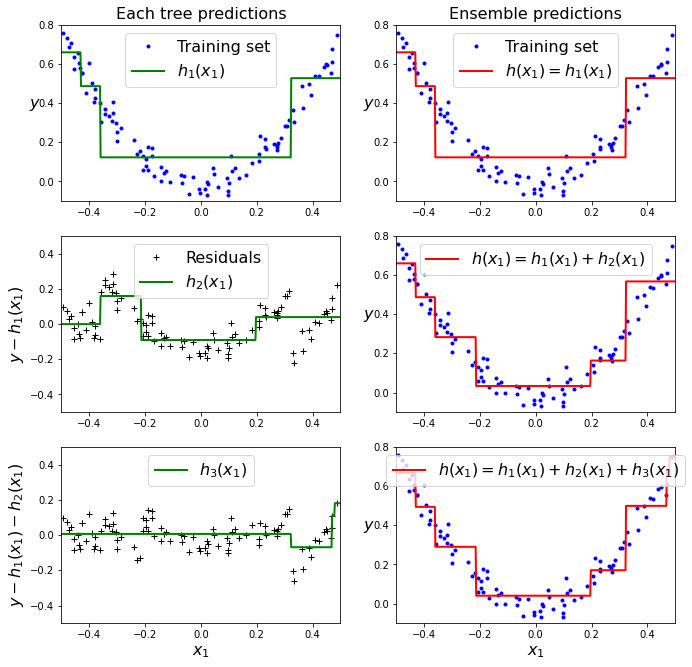

In [30]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Each tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

Of course, sklearn has implemented GradientBoosting under the API of <code>GradientBoostingClassifier</code> and <code>GradientBoostingRegressor</code>

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt3 = GradientBoostingRegressor(max_depth=2, n_estimators=3, 
                                  learning_rate=1.0, random_state=42)
gbrt3.fit(X, y)

gbrt200 = GradientBoostingRegressor(max_depth=2, n_estimators=200, 
                                    learning_rate=0.1, random_state=42)
gbrt200.fit(X, y)

gbrt3

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


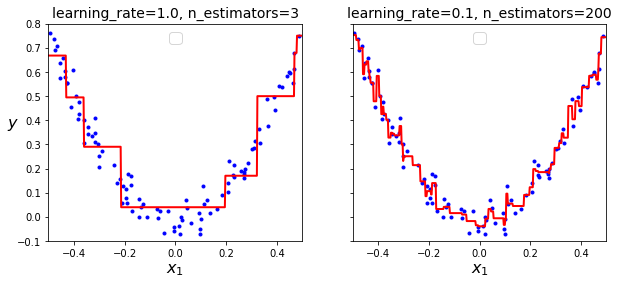

In [43]:
_, ax = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(ax[0]) #set the current ax so plot_predictions know which subplots
plot_predictions([gbrt3], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt3.learning_rate, gbrt3.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(ax[1])
plot_predictions([gbrt200], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt200.learning_rate, gbrt200.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

The <code>learning_rate</code> hyperparameter scales the contribution of each tree.  If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better.   

Here, the left one has too few trees (underfitting), while the right one has way too many trees (overfitting)

#### How to know how many trees?

The simplest way is to iterate the number of trees and if the validation errors do not decrease further, we should stop.  This method is also known as **Early Stopping**.

Sklearn has implemented this in <code>staged_predict</code> which returns an iterator over the predictions made by the ensemble at each stage of training.  Thus, we can easily plot the validation errors.

Here is the code:

In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [59]:
min_error = np.min(errors)

No handles with labels found to put in legend.


Text(0.5, 0, '$x_1$')

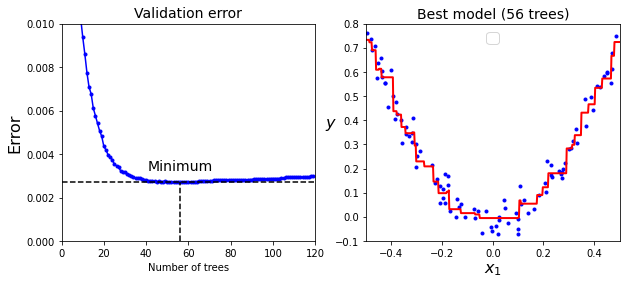

In [64]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)


Above method is a simply yet effective method to find the optimal number of trees.  In case you want to fit a gradient boosting at the same time of find the number of trees by using <code>warm_start</code> which basically keep existing previous trees when we called fit(), which allows incremental training.  Here is. how we can implement like this:

In [67]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, 
                                 random_state=42)

min_val_error = np.inf
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0  #reset
    else:
        error_going_up += 1
        #if the validation error does not improve for 5 iterations
        #we stop
        if error_going_up == 5:
            break  # early stopping
            
print("Current no. of trees: ", gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

Current no. of trees:  61
Minimum validation MSE: 0.002712853325235463


#### XGBoost

XGBoost is an optimized distributed gradient boosting, designed to be more efficient, flexible, and portable (Chen and Guestrin 2016).  In fact, XGBoost is often an important component of the winning entries in ML competitions (e.g., Kaggle).  XGBoost also offers several nice features, such as automatically taking care of early stopping: XGBoost’s API is quite similar to Scikit-Learn’s:

In [76]:
#make sure to pip install xgboost
#for mac guys, do "brew install libomp" which installs openMP library
#required for XGBoost

import xgboost

xgb_reg = xgboost.XGBRegressor() 

#not improved after 2 iterations
xgb_reg.fit(X_train, y_train,
                eval_set=[(X_test, y_test)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)  #notice we are using mse while xgb uses root mse

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129

MSE: 0.0026308690413069744


Let's look at time

In [77]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train)
%timeit GradientBoostingRegressor().fit(X_train, y_train)

12 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.9 ms ± 325 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Limitations of Boosting

Let's summarize some useful info about Gradient Boosting:

Advantages:
1. Extremely powerful - especially useful for heterogeneous data (e.g., house price, number of bedrooms).  However, when we talk about homogeneous data such as images, videos, audio, text, they are homogeneous in the sense that they share same scale and unit of measure.  In these cases, deep learning works better.  This make sense because Trees expect features that are independent, however, deep learning expect the features to be correlated in some sense.
2. Does not require huge sample sizes for good prediction.  It is actually good and bad.  Good is that you do not need to have much samples, but let's say you have 10m data of images.  Deep learning is method that benefits more from huge data, compared to Gradient Boosting, since deep learning is able to represent these data in a complex manner  (However!  designing architecture for deep learning is a difficult thing rather, and often is a trial and error!)

Disadvantages:
1. They cannot be parallelized.  Obvious since they are sequential predictors.
2. They can easily overfit, thus require careful choice of estimators or the use of regularization.  Can be easily fixed with early-stopping or cross-validation selection of hyperparameters